# CSRNet

In this notebook, we implement the CSRNet architecture for crowd counting using Keras. We follow the general guidelines outlined in the paper.

*   We begin by downloading the dataset and providing some quick visualizations.

*   The next step involves generating ground truths, specifically, **density maps**.

*   Following that, we perform a train-validation-test split, allocating 20% of the [Mall dataset](https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html) as the test set.

*   Afterward, we design the architecture using **Keras** and proceed with inference.

*   During the **inference** phase, our focus is on the Mean Absolute Error (**MAE**) metric.

While we conducted **several experiments**, we have chosen to highlight results from only four of them for clarity.

## General

**Run this**, since it's general for all the experiments.

In [ ]:
import os
import sys
import json
import random
import math
import scipy.io as io
from tqdm import tqdm
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm as CM
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.initializers import RandomNormal
from keras.optimizers import SGD, Nadam, RMSprop, Adam
from keras.models import Model, Sequential, model_from_json
from keras.layers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence

import requests
from google.colab import drive, runtime
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Functions for density map generation:

In [ ]:

def gaussian_filter_density(ground_truth):
    '''Generates a density map using Gaussian filter transformation.'''
    density = np.zeros(ground_truth.shape, dtype=np.float32) # Initialize an empty density map with the same shape as the GT
    ground_truth_count = np.count_nonzero(ground_truth) # count of people in the image

    if ground_truth_count == 0: # no people in the image
        return density

    # Find out the K nearest neighbours for each non-zero point using a KDTree
    index_of_nonzero_elements = np.nonzero(ground_truth)
    points = np.array(list(zip(index_of_nonzero_elements[1].ravel(), index_of_nonzero_elements[0].ravel())))
    leafsize = 2048

    # build KDTree
    tree = KDTree(points.copy(), leafsize=leafsize)
    # query KDTree
    distances, _ = tree.query(points, k=4) # 3+1

    for i, point in enumerate(points): # for every person in the image
        point_2d = np.zeros(ground_truth.shape, dtype=np.float32)
        point_2d[point[1], point[0]] = 1.
        if ground_truth_count > 1:
            # sigma = beta * d_bar = 0.3 * (d1 + d2 + d3) / 3 = 0.1 * (d1 + d2 + d3)
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(ground_truth.shape))/2./2. # case: 1 point (person)

        # Convolve with the gaussian filter
        density += gaussian_filter(point_2d, sigma, mode='constant')
    return density

In [ ]:
def plot_histogram_with_median(data):
    """Plots histogram of count of people detected in the images."""
    median = np.median(data)
    plt.hist(data, bins=20)
    plt.axvline(median, color='r', linestyle='--')
    plt.text(1.05*median, 100, 'Median', color='r')
    plt.xlabel('Number of people in the frame')
    plt.show()

def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function)
    loss = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

    return loss

def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(history.epoch) + 1), history.history['loss'], label='train loss')
    plt.plot(range(1, len(history.epoch) + 1), history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.xticks(range(1, len(history.epoch) + 1))
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def test_model(chk_point_filepath, test_imgs, test_labels):
    CSRNet.load_weights(chk_point_filepath)
    mse_error = 0
    mae_error = 0
    mape_error = 0
    N = len(test_labels)

    for i, (x, y) in tqdm(enumerate(zip(test_imgs, test_labels)), total=len(test_labels)):
        x = np.reshape(np.asarray(x), (1, x.shape[0], x.shape[1], x.shape[2]))
        prediction = CSRNet.predict(x, verbose=0)
        mse_error += np.mean(np.square(np.sum(prediction) - y))
        mae_error += np.mean(np.abs(np.sum(prediction) - y))
        mape_error += np.mean(np.abs((np.sum(prediction) - y) / y)) * 100

    mse = round(mse_error / N, 2)
    mae = round(mae_error / N, 2)
    mape = round(mape_error / N, 2)

    return mse, mae, mape

def save_mod(model , str1 , str2):
    model.save_weights(str1)
    model_json = model.to_json()
    with open(str2, "w") as json_file:
        json_file.write(model_json)

## Download dataset

**Important**: Run this only the first time!

In [ ]:
# Define the URL of the zip file
url = 'https://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip'

# Define the destination path in Google Drive
destination_path = '/content/drive/MyDrive/CrowdCounting/Data/'
# mall_dataset folder is contained in the zip

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Download the file
response = requests.get(url, stream=True)
zip_path = os.path.join(destination_path, 'mall_dataset.zip')

with open(zip_path, 'wb') as f:
    shutil.copyfileobj(response.raw, f)

# Extract the contents of the zip file
shutil.unpack_archive(zip_path, destination_path)

# Clean up: remove the downloaded zip file
os.remove(zip_path)

In [ ]:
file_path = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/readme.txt'

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read the contents of the file
    file_contents = file.read()

# Print the contents of the file
print(file_contents)

mall_feat.mat contains features used in [1] and [2].
mall_gt.mat contains the ground truth.

[1] Cumulative Attribute Space for Age and Crowd Density Estimation 
K. Chen, S. Gong, T. Xiang, and C. C. Loy 
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, 2013 (CVPR, Oral)


[2] Feature Mining for Localised Crowd Counting 
K. Chen, C. C. Loy, S. Gong, and T. Xiang 
British Machine Vision Conference, Surrey, United Kingdom, 2012 (BMVC 2012)


## Creating density maps

**Important**: Run this only the first time!

First we load the data.

In [ ]:
%ls /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/ | wc -l

2001


There is also Thumbs.db object, so 2000 images total.

In [ ]:
directory_path = "/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/"

# List all files in the directory
file_list = os.listdir(directory_path)

# Check if "Thumbs.db" exists in the list
if "Thumbs.db" in file_list:
    # Construct the full file path
    thumbs_db_path = os.path.join(directory_path, "Thumbs.db")

    # Delete the file
    os.remove(thumbs_db_path)
    print("Thumbs.db deleted successfully.")
else:
    print("Thumbs.db not found in the directory.")

Thumbs.db deleted successfully.


In [ ]:
mall_dataset_folder = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/'
mall_imgs_folder = mall_dataset_folder + 'frames/'
img_paths = []
for img_path in glob(os.path.join(mall_imgs_folder, '*.jpg')):
  img_paths.append(img_path)
print(f'Number of images: {len(img_paths)}.\n')

Number of images: 2000.



In [ ]:
mall_gt = io.loadmat(os.path.join(mall_dataset_folder, 'mall_gt.mat'))
mall_head_positions_gt = mall_gt['frame'][0]

Let's check the histogram of the number of heads in the dataset:

In [ ]:
num_heads_list = []
for gt in mall_head_positions_gt:
  n_heads = len(gt[0][0][0])
  num_heads_list.append(n_heads)

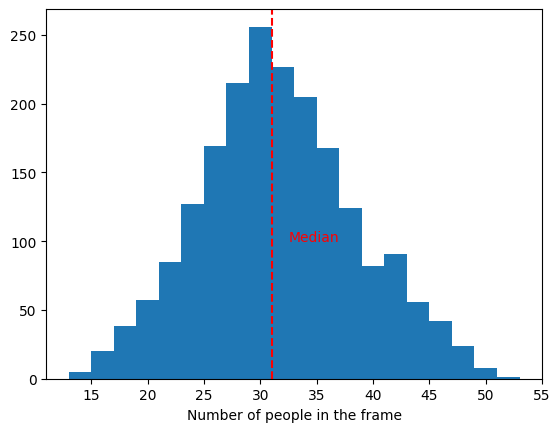

In [ ]:
plot_histogram_with_median(num_heads_list)

Let's visualize an image and its ground truth:

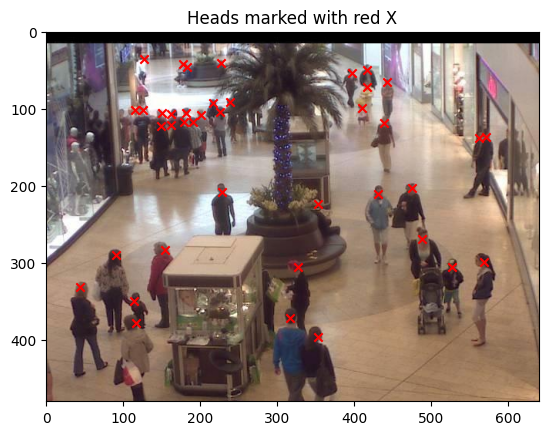

In [ ]:
img_index = 22
img = plt.imread(img_paths[img_index])
heads_gt = mall_head_positions_gt[img_index][0][0][0]

plt.imshow(img)
plt.scatter(heads_gt[:, 0], heads_gt[:, 1], marker='x', color='red') # Plot red X on each head
plt.title("Heads marked with red X")
plt.show()

Let's create and visualize a density map.

In [ ]:
# We use heads_gt and img from above

# Create a zero matrix of image size
k = np.zeros((img.shape[0],img.shape[1]))

# Generate hot encoded matrix of sparse matrix
for j in range(len(heads_gt)):
    if int(heads_gt[j][1]) < img.shape[0] and int(heads_gt[j][0]) < img.shape[1]:
        k[int(heads_gt[j][1]), int(heads_gt[j][0])] = 1

# Generate density map
k = gaussian_filter_density(k)

# Downsample the density map -> this will be needed for the CSRNet, because VGG downscales the images.
density_map = cv2.resize(k, (int(k.shape[1] / 8), int(k.shape[0] / 8)),
                            interpolation=cv2.INTER_CUBIC) * (8 ** 2)
density_map = np.expand_dims(density_map, axis=2)

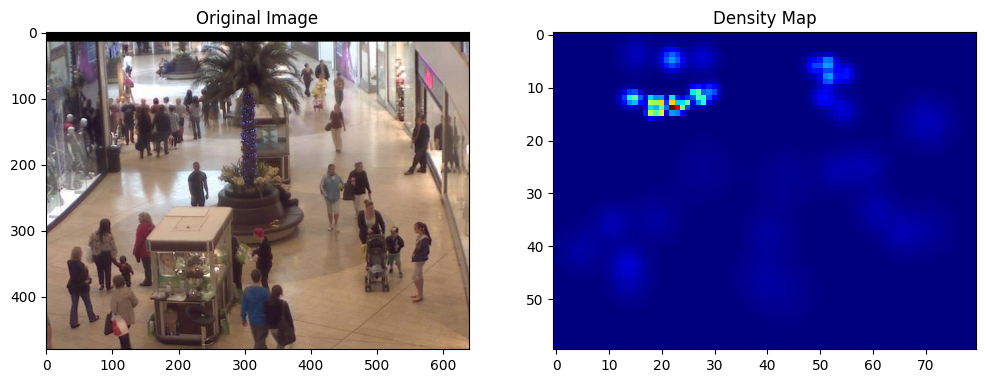

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image on the first subplot
axs[0].imshow(img)
axs[0].set_title('Original Image')

# Plot the density map on the second subplot
axs[1].imshow(density_map, cmap='jet')
axs[1].set_title('Density Map')

# Show the figure
plt.show()

In [ ]:
def create_density_maps_mall(imgs_paths, head_positions_gt, save_path):

    for i, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):
        img = plt.imread(img_path)

        ground_truth = head_positions_gt[i][0][0][0]

        # Create a zero matrix of image size
        k = np.zeros((img.shape[0],img.shape[1]))

        # Generate hot encoded matrix of sparse matrix
        for j in range(len(ground_truth)):
            if int(ground_truth[j][1]) < img.shape[0] and int(ground_truth[j][0]) < img.shape[1]:
                k[int(ground_truth[j][1]), int(ground_truth[j][0])] = 1

        # Generate density map
        k = gaussian_filter_density(k)

        # Downsample the density map
        density_map = cv2.resize(k, (int(k.shape[1] / 8), int(k.shape[0] / 8)),
                                   interpolation=cv2.INTER_CUBIC) * (8 ** 2)
        density_map = np.expand_dims(density_map, axis=2)

        # File path to save density map
        file_path = save_path + f'/IMG_{i+1}.npy'
        np.save(file_path, density_map)

In [ ]:
save_path = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/density_maps/'

# Create directory if it doesn't exist
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

create_density_maps_mall(img_paths, mall_head_positions_gt, save_path)

100%|██████████| 2000/2000 [50:05<00:00,  1.50s/it]


In [ ]:
%ls /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/density_maps/ | wc -l

2000


## Modelling

Split the data, create DataLoader and train the model.

**Run this**, making sure to select the proper hyperparameters

Train-val-test split:

In [ ]:
# Load images and density maps
path_images = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/'
path_density_maps = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/density_maps/'

img_names = sorted(os.listdir(path=path_images))
den_names = sorted(os.listdir(path=path_density_maps))

random_state = 42

# Train_val - test split:
test_proportion = 0.2
train_val_img_names, test_img_names = train_test_split(img_names, test_size=test_proportion, random_state=random_state)
train_val_den_names, test_den_names = train_test_split(den_names, test_size=test_proportion, random_state=random_state)

# Train - val split
val_proportion = 0.2
train_img_names, val_img_names = train_test_split(train_val_img_names, test_size=val_proportion, random_state=random_state)
train_den_names, val_den_names = train_test_split(train_val_den_names, test_size=val_proportion, random_state=random_state)

In [ ]:
# Data generator class

class CrowdCountingDataGenerator(Sequence):
    def __init__(self, image_names, density_names, batch_size=1):
        self.image_names = image_names
        self.density_names = density_names
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.image_names))

    def __len__(self):
        return int(np.ceil(len(self.image_names) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indexes)
        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        X = []
        y = []

        for i, idx in enumerate(batch_indexes):
            img = preprocess_input(cv2.cvtColor(cv2.imread(path_images + self.image_names[idx]), cv2.COLOR_BGR2RGB))
            density_map = np.load(path_density_maps + self.density_names[idx])

            X.append(img)
            y.append(density_map)

        return np.array(X), np.array(y)

Model architecture:

*   First 10 layers are from VGG16, pretrained on ImageNet and frozen.
*   Then we add sequentially conv layers with dilatation, and RandomNormal initialization.

In [ ]:
def CSRNet():

    input_shape = (480, 640, 3)
    kernel = (3, 3)
    init = RandomNormal(stddev=0.01, seed=123)

    model = Sequential()

    front_end = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in front_end.layers[:-6]:
        # layer.trainable = False # TODO: Uncomment if you want VGG16 to be frozen
        model.add(layer)

    # Back-end
    model.add(Conv2D(512, kernel, activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same', name='dil_A1'))
    model.add(Conv2D(512, kernel, activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same', name='dil_A2'))
    model.add(Conv2D(512, kernel, activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same', name='dil_A3'))
    model.add(Conv2D(256, kernel, activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same', name='dil_A4'))
    model.add(Conv2D(128, kernel, activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same', name='dil_A5'))
    model.add(Conv2D(64, kernel, activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same', name='dil_A6'))
    model.add(Conv2D(1, (1, 1), dilation_rate = 1, kernel_initializer = init, padding = 'same', name='dil_A7')) # no activation

    return model

In [ ]:
CSRNet = CSRNet()
CSRNet.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 480, 640, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 480, 640, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 240, 320, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 240, 320, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 240, 320, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 120, 160, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 120, 160, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 120, 160, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 120, 160, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 60, 80, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 60, 80, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 60, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dil_A1 (Conv2D)                      │ (None, 60, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dil_A2 (Conv2D)                      │ (None, 60, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dil_A3 (Conv2D)                      │ (None, 60, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dil_A4 (Conv2D)                      │ (None, 60, 80, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dil_A5 (Conv2D)                      │ (None, 60, 80, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dil_A6 (Conv2D)                      │ (None, 60, 80, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dil_A7 (Conv2D)                      │ (None, 60, 80, 1)           │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,903,681 (53.04 MB)

 Trainable params: 13,903,681 (53.04 MB)

 Non-trainable params: 0 (0.00 B)

Modify the parameters here:

In [ ]:
# Optimizers
sgd = SGD(learning_rate=1e-7, weight_decay = (5*1e-4), momentum=0.95)
adam = Adam(learning_rate=1e-7)
# The following two didn't work well
rms = RMSprop(learning_rate=1e-4, momentum=0.7, weight_decay=0.0001)
nadam = Nadam(learning_rate=1e-4)

batch_size = 16 # 1, 16, 32
optimizer = adam # sgd, adam
loss = 'mse' # 'mse', 'mae', eucldiean_distance_loss
metrics_list = ['mae'] # change to mae if you use mse loss
epochs = 40

Fit the model:

In [ ]:
CSRNet.compile(optimizer=optimizer, loss=loss, metrics=metrics_list)

# Create data generators
train_generator = CrowdCountingDataGenerator(train_img_names, train_den_names, batch_size=batch_size)
val_generator = CrowdCountingDataGenerator(val_img_names, val_den_names, batch_size=batch_size)

checkpoint_filepath = '/content/drive/MyDrive/CrowdCounting/Models/checkpoint_adam.weights.h5'
model_chkpnt = ModelCheckpoint(filepath=checkpoint_filepath,
                               save_weights_only=True,
                               monitor='val_mae',
                               mode='min',
                               save_freq='epoch',
                               save_best_only=True)

es = EarlyStopping(monitor='val_mae',
                   mode='min',
                   patience=5) # 30

# Use the following in combination with SGD
reduce_lr = ReduceLROnPlateau(monitor='val_mae', # 'val_mse'
                              mode='min',
                              patience=3, # 4
                              factor=0.2,
                              min_lr=1e-7)

nan_loss = TerminateOnNaN()

callbacks = [model_chkpnt,
             # reduce_lr, # TODO: Comment this out if using Adam
             es,
             nan_loss]

history = CSRNet.fit(train_generator,
                     validation_data=val_generator,
                     epochs=epochs,
                     #use_multiprocessing=True,
                     #workers=4,
                     callbacks=callbacks)

print('\nTraining complete.')

# Load the best weights
CSRNet.load_weights(checkpoint_filepath)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 1375s 15s/step - loss: 9.0911e-04 - mae: 0.0186 - val_loss: 7.9504e-04 - val_mae: 0.0168
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - loss: 7.3854e-04 - mae: 0.0163 - val_loss: 7.1084e-04 - val_mae: 0.0153
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 6.6082e-04 - mae: 0.0149 - val_loss: 6.5735e-04 - val_mae: 0.0142
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 6.2255e-04 - mae: 0.0140 - val_loss: 6.1943e-04 - val_mae: 0.0134
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 5.9538e-04 - mae: 0.0132 - val_loss: 5.9111e-04 - val_mae: 0.0128
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - loss: 5.6558e-04 - mae: 0.0126 - val_loss: 5.6895e-04 - val_mae: 0.0123
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 5.3612e-04 - mae: 0.0121 - val_loss: 5.5090e-04 - val_mae: 0.0120
Epoch 8/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 5.2297e-04 - mae: 0.0118 - val_loss: 5.3559e-04 - val_mae: 0.0116
Epoch 9/4

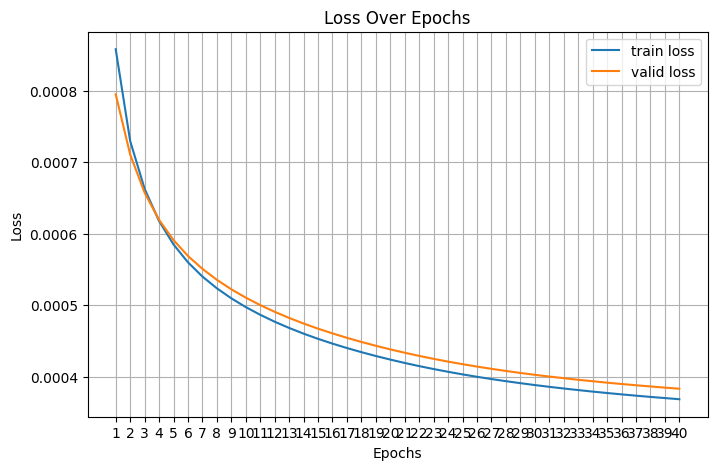

In [ ]:
plot_learning_curves(history)

## Testing

Computing MAE for the Test dataset, and visualizing predictions.

In [ ]:
Test_imgs = []
Test_density = []
for img_name, den_name in tqdm(zip(test_img_names, test_den_names), total=len(test_img_names)):
  img = preprocess_input(cv2.cvtColor(cv2.imread(path_images + img_name), cv2.COLOR_BGR2RGB))
  den = np.load(path_density_maps + den_name)
  Test_imgs.append(img)
  Test_density.append(den)
Test_imgs = np.asarray(Test_imgs)
Test_density = np.asarray(Test_density)

100%|██████████| 400/400 [05:09<00:00,  1.29it/s]


In [ ]:
mall_dataset_folder = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/'

mall_gt = io.loadmat(os.path.join(mall_dataset_folder, 'mall_gt.mat'))
mall_head_positions_gt = mall_gt['frame'][0]

num_heads_list = []
for gt in mall_head_positions_gt:
  n_heads = len(gt[0][0][0])
  num_heads_list.append(n_heads)

test_indices = [img_names.index(name) for name in test_img_names]
Test_labels = [num_heads_list[idx] for idx in test_indices]

print(len(Test_labels))

400


In [ ]:
mse_test, mae_test, mape_test = test_model(checkpoint_filepath, Test_imgs, Test_labels)

print(f'\n\nMSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}')

100%|██████████| 400/400 [00:54<00:00,  7.38it/s]



MSE: 47.95, MAE: 5.53, MAPE: 18.3


Let's visualize some predictions:

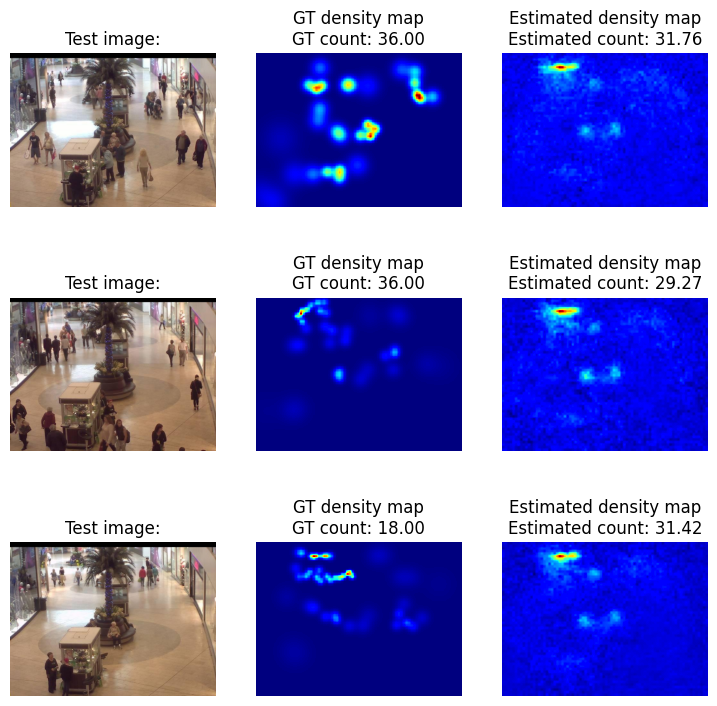

In [ ]:
to_print = 3
plt.figure(figsize=(9, 3 * to_print))

for i, (img_name, den_map) in enumerate(zip(test_img_names, Test_density)):
    if i == to_print: break

    # img_standardized = standardize_imagenet(path_images + img_name)
    img_standardized = preprocess_input(cv2.cvtColor(cv2.imread(path_images + img_name), cv2.COLOR_BGR2RGB))
    estimated_den_map = CSRNet.predict(np.reshape(np.asarray(img_standardized),(1, img_standardized.shape[0], img_standardized.shape[1], img_standardized.shape[2])), verbose=0)

    img = cv2.imread(path_images + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(to_print, 3, i * 3 + 1)
    plt.axis("off")
    plt.title("Test image:")
    plt.imshow(img)

    plt.subplot(to_print, 3, i * 3 + 2)
    plt.axis("off")
    plt.title("GT density map:")
    plt.title(f"GT density map\nGT count: {Test_labels[i]:.2f}")
    plt.imshow(den_map , cmap = CM.jet)
    print()

    estimated_count = np.sum(estimated_den_map)
    plt.subplot(to_print, 3, i * 3 + 3)
    plt.axis("off")
    plt.title(f"Estimated density map\nEstimated count: {estimated_count:.2f}")
    plt.imshow(estimated_den_map.reshape((estimated_den_map.shape[1], estimated_den_map.shape[2], 1)) , cmap = CM.jet)

In [ ]:
runtime.unassign()


Result:

> MSE: 531.84, MAE: 22.17, MAPE: 69.74\
> Density maps look very bad. => model didn't learn\
> Terminated after 3 epochs due to NaN loss in 4th epoch.